# Outage Risk Map Generation

By combining power outage data with population data, extreme outage events are identified, and an index is calculated to assess the outage risk for each county. The electric deficit for a county is defined as follows:

$$
\text{electric deficit} = \frac{1}{2} \times (\text{max outage} \times (T_j + T_r))
$$

![Figure](../figure/outage.png)

where:
- $T_j$ is the impact duration, and
- $T_r$ is the recovery duration.

Since only extreme outage events pose significant challenges to a county's power grid, only these events are considered. An outage begins when more than 5% of a county's population experiences a power outage and ends when fewer than 5% of the population is affected.

- Outage Risk Score: While the previous study was based on the count of extreme outages, we calculate an **Outage Score** for each county by dividing the product of Impact Duration and Recovery Duration by the county's population, to create an Outage Map.

- Outage Risk Map Usage: This map is used after **EV Location Optimization**. Specifically, during post-processing of DC-FAST type EV stations, we remove DC-FAST stations in the top 5% of areas where extreme power outages occur.

### Reference: 
Abdelmalak, Michael, et al. "Quantitative resilience-based assessment framework using eagle-i power outage data." IEEE Access 11 (2023): 7682-7697.

## 1. Make Outage Variable Data

Following the same resilience metric conventions, a few metrics are defined to measure the behavior of extreme outages

In [3]:
import os
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [4]:
# Path to the folder containing outage data
outage_data_folder = "/home/sehoon/Desktop/outage/"

# Load and preprocess population data
county_population_data = gpd.read_file("/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/census_tract_pop/census_tract_pop.shp")
county_population_data['Total popu'] = pd.to_numeric(county_population_data['Total popu'], errors='coerce')

# Convert population to customer count (assuming 2 people per customer)
county_population_data['customers'] = county_population_data['Total popu'] / 2

# Calculate upper threshold (αh) and lower threshold (αl) reflecting 85% coverage
county_population_data['αh'] = county_population_data['customers'] * 0.25  # Upper threshold (25% of customers)
county_population_data['αl'] = county_population_data['customers'] * 0.05  # Lower threshold (5% of customers)

# Process all CSV files in the folder
all_files = [f for f in os.listdir(outage_data_folder) if f.endswith('.csv')]

def process_outage_file(file):
    file_path = os.path.join(outage_data_folder, file)
    outage_data = pd.read_csv(file_path)
    outage_data['county'] = outage_data['county'] + " County"

    # Merge outage data with population data based on 'county'
    merged_data = pd.merge(outage_data, county_population_data, left_on='county', right_on='NAMELSAD_2', how='left')

    # Convert time columns and sort by time within each county
    merged_data['run_start_time'] = pd.to_datetime(merged_data['run_start_time'])
    merged_data.sort_values(by=['county', 'run_start_time'], inplace=True)

    # Function to calculate event durations and metrics
    def calculate_event_durations(group):
        event_start = None
        max_outage = 0
        max_outage_time = None
        extreme_event = False
        event_records = []

        for i, row in group.iterrows():
            if row['sum'] >= row['αl']:
                if event_start is None:
                    event_start = row['run_start_time']
                    max_outage = row['sum']
                    max_outage_time = row['run_start_time']
                    extreme_event = False
                else:
                    max_outage = max(max_outage, row['sum'])
                    if row['sum'] >= row['αh']:
                        extreme_event = True
            else:
                if event_start is not None:
                    event_end = row['run_start_time']
                    event_duration = (event_end - event_start).total_seconds() / 3600
                    impact_duration = (max_outage_time - event_start).total_seconds() / 3600 or 0.25
                    recovery_duration = (event_end - max_outage_time).total_seconds() / 3600 or 0.25

                    if extreme_event:
                        event_records.append({
                            'county': row['county'],
                            'start_time': event_start,
                            'end_time': event_end,
                            'event_duration': event_duration,
                            'impact_duration': impact_duration,
                            'recovery_duration': recovery_duration,
                            'max_outage': max_outage,
                            'impact_rate': max_outage / impact_duration,
                            'recovery_rate': max_outage / recovery_duration,
                            'recovery_impact_ratio': recovery_duration / impact_duration
                        })

                    # Reset for the next event
                    event_start = None
                    max_outage = 0
                    max_outage_time = None
                    extreme_event = False

        return pd.DataFrame(event_records)

    # Group by county and calculate event metrics
    county_groups = merged_data.groupby('county')
    extreme_events = []

    for _, group in county_groups:
        event_data = calculate_event_durations(group)
        if not event_data.empty:
            extreme_events.append(event_data)

    # Return combined extreme events for this file
    if extreme_events:
        return pd.concat(extreme_events, ignore_index=True)
    else:
        return pd.DataFrame()

# Process all files in parallel
extreme_events_list = Parallel(n_jobs=-1)(
    delayed(process_outage_file)(file) for file in all_files
)

# Combine all extreme events data into a single DataFrame
extreme_events_combined = pd.concat(extreme_events_list, ignore_index=True)

# Save the combined data to a CSV file
extreme_events_combined.to_csv('extreme_outages.csv', index=False)

print("Processing complete. Extreme outages saved to 'extreme_outages.csv'")

Processing complete. Extreme outages saved to 'extreme_outages.csv'


## 2. Electric Deficit Calculation

In [5]:
# Load Census Tract and County Shapefiles
census_tracts = gpd.read_file("/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/census_tract_pop/census_tract_pop.shp")
county_shapefile = gpd.read_file("/home/sehoon/Desktop/data/county/Georgia_county.shp")

# Calculate population per county from census tracts
# Ensure population is numeric, fill missing values
census_tracts['Total popu'] = census_tracts['Total popu'].fillna(0).astype(int)

# Group by 'NAMELSAD_2' (county) to calculate total population per county
county_population = census_tracts.groupby('NAMELSAD_2')['Total popu'].sum().reset_index()
county_shapefile = county_shapefile.merge(county_population, left_on='NAMELSAD', right_on='NAMELSAD_2', how='left')

# Load and process outage data
outage = pd.read_csv("/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/extreme_outages.csv")

# Update specific rows where both impact_duration and recovery_duration are 0.25, setting them to 0.125
# 이건 매우 짧은 시간(15분) 만에 정전이 발생했다가 해결된 경우, Electric Deficit을 제대로 측정하지 못하는 문제를 해결하기 위함
outage.loc[(outage['impact_duration'] == 0.25) & (outage['recovery_duration'] == 0.25), 
           ['impact_duration', 'recovery_duration']] = 0.125

# Calculate Electric Deficit
outage['Area'] = (outage['impact_duration'] + outage['recovery_duration']) * outage['max_outage']
county_grouped = outage.groupby('county')['Area'].sum().reset_index()

# Step 3: Merge outage data with county shapefile based on 'NAMELSAD'
county_shapefile = county_shapefile.merge(county_grouped, left_on='NAMELSAD', right_on='county', how='left')
county_shapefile['Area'] = county_shapefile['Area'].fillna(0)
county_shapefile['Total popu'] = county_shapefile['Total popu'].fillna(0)
county_shapefile['Total popu'] = county_shapefile['Total popu'].replace(0, 1)

# Calculate the outage score as Area divided by Total population
county_shapefile['score'] = county_shapefile['Area'] / county_shapefile['Total popu']

# Save the result to a GeoPackage file
output_path = 'final_county_outage_score.gpkg'
county_shapefile.to_file(output_path, driver='GPKG')

print(f"GeoPackage saved to {output_path}")

GeoPackage saved to final_county_outage_score.gpkg


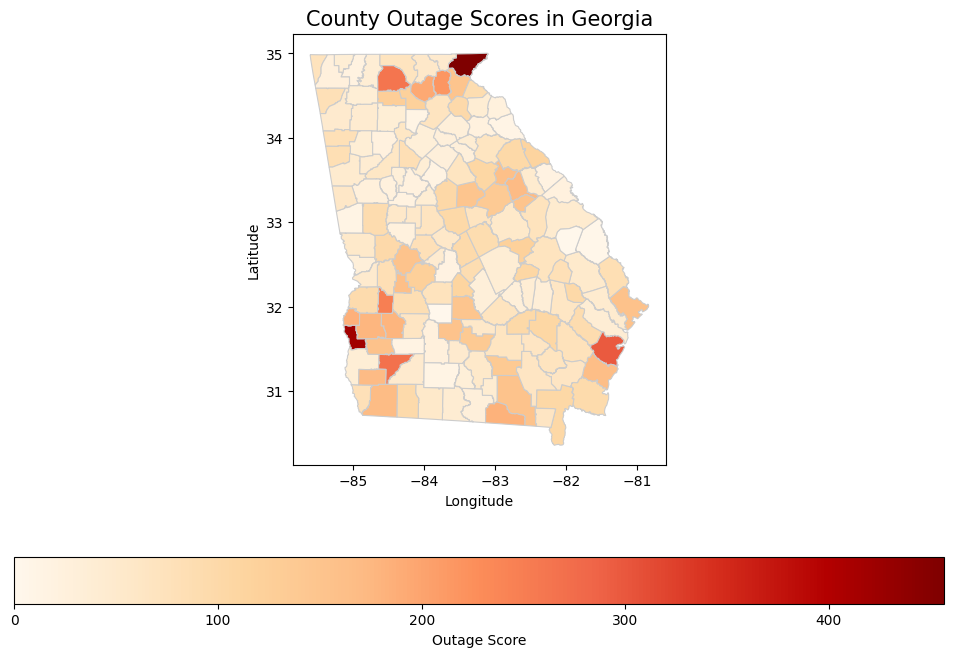

In [6]:
# Set up the figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the GeoDataFrame with the 'score' column as color, and customize the legend
county_shapefile.plot(column='score', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', 
                      legend=True, legend_kwds={'label': "Outage Score", 'orientation': "horizontal"})

# Add title and labels
ax.set_title('County Outage Scores in Georgia', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()